# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 2 parts:

1. Implementing loss functions, calculating gradients and implementing gradient descent.
2. Training and evaluating several classifiers.

## Submission guidelines:

Your submission should only include this jupyter notebook named HW1_ID.ipynb.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors.
7. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).
8. **TIP: When there is a TODO before a missing code segment (or function), you can continue without implementing it right away; you will be referred to the missing segment later in the exercise.**

Q: What files do we need to upload to moodle?

A: You should fill in the missing parts in this Jupyter notebook and then submit it via moodle (without any additional files).

Q: How do I make sure everything works before I submit?

A: You should restart your kernel and rerun all cells. Make sure you get the desired output and that you meet exercise requirements. **This is an important step. You should include your desired outputs in the output cells to make your code easier to understand.**

#### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools
import time

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# Data preprocessing


## Data download and processing Helper Code

In [2]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        print("Downloading, This might take several minutes.")
        last_update_time = time.time()
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        print("If not, delete the dataset folder and try again.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.
If not, delete the dataset folder and try again.


## Data Preprocessing Part 1

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization.

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
# portion from the test dataset a validation dataset for hyperparameter optimization
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
# test dataset, without overlap with train/validation
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

classes = ('plane', 'car')

    plane	    plane	      car	    plane


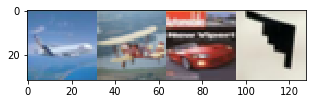

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print('\t'.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, n=4, convert_to_image=False));

## Data Preprocessing Part 2

We have included several image processing functions. Notice the following in particular: We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [6]:
# Final data preprocessing
# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(f"Shape of Training Set: {X_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}")
print(f"Shape of Test Set: {X_test.shape}")

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


# Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Read the code in the next cell and make sure you understand it. You might also find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.


In [7]:
class LinearClassifier(object):
    def __init__(self, X, y):
        """
        Class constructor. Use this method to initiate the parameters of
        your model (W)
        *** Subclasses will override this. ***

        Inputs:
        - X: array of data - a 2D array of size (num_instances=N, num_features)
        - y: 1-dimensional array of length N with binary labels

        This function has no return value

        """
        # initialize the weights with small numbers (multiply with 0.001 to scale the weights and prevent them from being too large)
        # the weights will be a 2D array of size (num_features, 1)        
        self.W = np.random.randn(X.shape[1], 1) * 0.001
        pass

    def predict(self, X):
        """
        Use the weight of the classifier to predict a label. 
        *** Subclasses will override this. ***

        Input: 2D array of size (num_instances, num_features).
        Output: 1D array of class predictions (num_instances, 1). 
        """
        # predict the labels of the data using the weights
        # the prediction will be a 1D array of size (num_instances, 1)
        # y_pred will contain only -1 (for negative values) or 1 values (for positive values)
        y_pred = np.sign(self.W.T.dot(X.T))
        # change -1 to 0
        # y_pred[y_pred == -1] = 0
        return y_pred

    def calc_accuracy(self, X, y):
        """
        Calculate the accuracy on a dataset as the percentage of instances 
        that are classified correctly. 

        Inputs:
        - W: array of weights
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        Returns:
        - accuracy as a single float
        """

        accuracy = 0.0
        ###########################################################################
        # TODO: Implement this method.                                            #
        ###########################################################################
        #                          START OF YOUR CODE                             #
        ###########################################################################

        # call self.predict to get the predictions for X
        predictions = self.predict(X)

        # calculate the accuracy of the predictions by comparing them to the labels y
        # np.squeeze is used to remove single-dimensional entries from the shape of an array (so that it is the same shape as the labels y)
        # y is converted to float to avoid errors with the comparison
        # the comparison results in a boolean array where True is treated like 1 and False is treated like 0
        
        #accuracy = np.mean(np.squeeze(predictions) == y.astype(float))
        accuracy = (np.sum(predictions == y) / len(y))
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################

        return accuracy


    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in every iteration.                       #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch                                                               #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #                                                                       #
        # Next, calculate the loss and gradient and update the weights using    #
        # the learning rate. Use the loss_history array to save the loss on     #
        # iteration to visualize the loss.                                      #
        #########################################################################
        num_instances = X.shape[0]
        loss_history = []
        loss = 0.0
        for i in range(num_iters):
            X_batch = None
            y_batch = None
            ###########################################################################
            # Create X_batch and y_batch. Call the loss method to get the loss value  # 
            # and grad (the loss function is being override, see the loss             #
            # function return values).                                                #
            # Finally, append each of the loss values created in each iteration       #
            # to loss_history.                                                        #
            ###########################################################################
            #                          START OF YOUR CODE                             #
            ###########################################################################

            # define the batch indices as random integers between 0 and the number of instances of size batch_size
            batch_indices = np.random.choice(num_instances, batch_size, replace=True)

            # get the batch data and labels for the sampled indices
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # calculate the loss and gradient
            loss, grad = self.loss(X_batch, y_batch)

            # append the loss to the loss history
            loss_history.append(loss)
            
            
            
            ###########################################################################
            #                           END OF YOUR CODE                              #
            ###########################################################################
            # TODO:                                                                   #
            # Perform parameter update                                                #
            # Update the weights using the gradient and the learning rate.            #
            ###########################################################################
            #                          START OF YOUR CODE                             #                                                         #
            ###########################################################################

            
            ###########################################################################
            #                       END OF YOUR CODE                                  #
            ###########################################################################

            # perform a parameter update
            # check if the shape of the gradient is the same as the shape of the weights
            if self.W.shape == grad.shape:
                self.W = self.W - learning_rate * grad
            else:
                self.W = self.W - learning_rate * grad.reshape(self.W.shape)

            # print the loss every 100 iterations during training to provide update about training progress
            if verbose and i % 100 == 0:
                print ('iteration %d / %d: loss %f' % (i, num_iters, loss))

        return loss_history


    def loss(self, X, y):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """

        # compute the loss function with MSE (usually used for regression problems)
        loss = np.mean(np.square(y - self.predict(X)))


        # compute the gradient as an array of the same shape as W, representing the derivative of the loss with respect to each weight
        grad = -2 * np.mean((y - self.predict(X)) * X, axis=0).reshape(self.W.shape)

        return loss, grad


## Linear perceptron
Our first linear classifier will include a linear function that maps images to score/scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

In the multiclass case, W will be a matrix that maps the input into scores (score for each class) and the final prediction will be the class with the highest score.
The binary case is a special case where you can choose to implement W as a 2 dim matrix or as a vector. The first option treats the binary problem as a multiclass problem with 2 classes, therefore, the prediction will be the class with the highest score. In case you choose to implement W as a vector (which map the input to a single score), the final prediction is done by:


if w·x+b > 0 classify the target as 1, else classify the target as 0.

**Important Note** - In this exercise we focus on the binary case, and you should implement W as a vector.

Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels.

Read the next code cell. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use `w` for convenience. You may initialize `w` randomly ([0,1] or [-1,1]).

Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(5 Points)**

In [8]:
class LinearPerceptron(LinearClassifier):
    # Classifier that uses Perceptron loss

    def __init__(self, X, y):
        ###########################################################################
        # Initiate the parameters of your model.                                  #
        # You can assume y takes values 0...K-1 where K is number of classes      #
        ###########################################################################
        #                          START OF YOUR CODE                             # 
        ###########################################################################
        
        # initialize the weights from 0 and 1 with small numbers (multiply with 0.001 to scale the weights and prevent them from being too large)
        self.W = np.random.randn(X.shape[1], 1) * 0.001

        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # Implement this method.                                                  #
        ###########################################################################
        #                          START OF YOUR CODE                             # 
        ###########################################################################

        # calculate the prediction
        # y_pred will be either 0 (for negaative values) or 1 (for positive values)
        y_pred = (self.W.T.dot(X.T))
        y_pred = np.where(y_pred < 0, 0, 1)
        y_pred = np.squeeze(y_pred)
             
        return y_pred
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################

    def loss(self, X_batch, y_batch):
        # perceptron_loss_vectorized will be implemented later
        return perceptron_loss_vectorized(self.W, X_batch, y_batch)

In [9]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

    plane	    plane	    plane	    plane


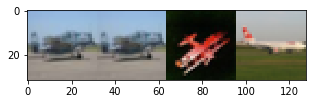

In [10]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True))
plt.show()

In [11]:
# predictions
print(' '.join('%9s' % classes[y_pred[j]] for j in range(4)))

    plane     plane       car     plane


## Evaluation 

Complete the class method `calc_accuracy`. **(5 Points)**

In [12]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  0.5796


**Explain why the accuracy on the training dataset is around 50% (remember, the model is not trained yet). **(5 Points)**** 

Answer: The model isn't updating the weights at any point, we just initialized the model. Given that the model is initialized randomly and that we have 2 classes (cars and planes) it makes sense that the accuracy is roughly 50% since we have a 50% chance of guessing correctly.

## Perceptron loss

Your code for this section will all be written in the next cell. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in the next cell. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  **(15 points)**

In [13]:
def perceptron_loss_naive(W, X, y):
    """
    Structured perceptron loss function, naive implementation (with loops)
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Compute the perceptron loss as learned in class. Start by iterating over  #
    # over all instances and calculate the score and true score for each.       #
    # Now, for each class determine if the prediction is correct and update the #
    # loss over all mistakes.                                                   #
    # Compute the gradient of the loss function and store it as dW.             #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed.                                                   #
    #############################################################################
    
    # calculated score
    predicted_score = np.dot(X, W)

    # get the number of instances
    num_instances = X.shape[0]

    # transform y from 0/1 to -1/1
    transformed_y = 2 * y - 1
    
    # iterate over the instances and get the score for the correct class
    for instance in range(num_instances):
        current_t = transformed_y[instance]
        current_z = predicted_score[instance]
        # check if the prediction is correct
        if current_t*current_z < 0: # if the prediction is incorrect
            loss += -1*current_t*current_z
            # Reshape X[instance] to match the shape of dW
            dW += -current_t * X[instance].reshape(-1, 1)
        else: # if the prediction is correct
            loss += 0
            dW += 0

    # calculate the average loss
    loss /= X.shape[0]
    # calculate the average gradient
    dW /= X.shape[0]

    
    
    
    
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [14]:
W = np.random.randn(3073, 1) * 0.0001

In [15]:
%%time
loss_naive, _ = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive))

loss: 0.353441
CPU times: total: 0 ns
Wall time: 23.6 ms


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below. **(15 points)**

In [16]:
def perceptron_loss_vectorized(W, X, y):
    """
    Vectorized version of perceptron_loss_naive. instead of loops, should use 
    numpy vectorization.

    Inputs and outputs are the same as perceptron_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Implement a vectorized version of the perceptron loss, storing the       #
    # result in loss and the gradient in dW                                     #
    #############################################################################

    # Transform y from 0/1 to -1/1
    transformed_y = 2 * y - 1

    # Calculate scores
    scores = np.dot(X, W).squeeze()

    # Identify incorrect predictions
    incorrect_predictions_mask = transformed_y * scores < 0

    # Compute loss for incorrect predictions
    loss = np.sum(-transformed_y[incorrect_predictions_mask] * scores[incorrect_predictions_mask])

    # Compute gradient only for incorrect predictions
    dW = -np.dot(X[incorrect_predictions_mask].T, transformed_y[incorrect_predictions_mask].reshape(-1, 1))

    # Average the loss and gradient over the number of samples
    num_instances = X.shape[0]
    loss /= num_instances
    dW /= num_instances   
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [17]:
%%time
loss_vectorized, _ = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss_vectorized))

loss: 0.353441
CPU times: total: 0 ns
Wall time: 12.2 ms


You might not see big changes in time due to other computing factors. In big enough datasets it would be crucial to use the vectorized version.

We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in the `LinearClassifier` class. (**15 points**)

In [18]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7, 
                                num_iters=1500, verbose=True)

iteration 0 / 1500: loss 1.033269


iteration 100 / 1500: loss 0.735852
iteration 200 / 1500: loss 0.509530
iteration 300 / 1500: loss 0.552383
iteration 400 / 1500: loss 0.369529
iteration 500 / 1500: loss 0.440633
iteration 600 / 1500: loss 0.456691
iteration 700 / 1500: loss 0.416194
iteration 800 / 1500: loss 0.412410
iteration 900 / 1500: loss 0.447183
iteration 1000 / 1500: loss 0.345825
iteration 1100 / 1500: loss 0.358590
iteration 1200 / 1500: loss 0.311360
iteration 1300 / 1500: loss 0.315940
iteration 1400 / 1500: loss 0.244688
CPU times: total: 2.36 s
Wall time: 6.17 s


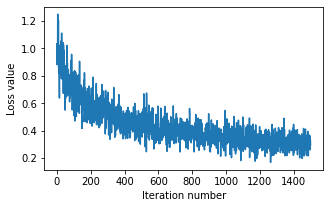

In [19]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.7431
Testing accuracy:  0.767


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. **(5 points)**


iteration 0 / 1500: loss 2.152160
iteration 100 / 1500: loss 0.815682
iteration 200 / 1500: loss 0.468216
iteration 300 / 1500: loss 0.466366
iteration 400 / 1500: loss 0.381893
iteration 500 / 1500: loss 0.365970
iteration 600 / 1500: loss 0.338069
iteration 700 / 1500: loss 0.407620
iteration 800 / 1500: loss 0.326615
iteration 900 / 1500: loss 0.269616
iteration 1000 / 1500: loss 0.343385
iteration 1100 / 1500: loss 0.283394
iteration 1200 / 1500: loss 0.270829
iteration 1300 / 1500: loss 0.199626
iteration 1400 / 1500: loss 0.288670


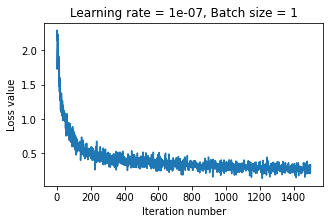

iteration 0 / 1500: loss 1.348208
iteration 100 / 1500: loss 0.682505
iteration 200 / 1500: loss 0.461977
iteration 300 / 1500: loss 0.470926
iteration 400 / 1500: loss 0.383585
iteration 500 / 1500: loss 0.443376
iteration 600 / 1500: loss 0.293538
iteration 700 / 1500: loss 0.318666
iteration 800 / 1500: loss 0.325126
iteration 900 / 1500: loss 0.409738
iteration 1000 / 1500: loss 0.312233
iteration 1100 / 1500: loss 0.273483
iteration 1200 / 1500: loss 0.291147
iteration 1300 / 1500: loss 0.375977
iteration 1400 / 1500: loss 0.254644


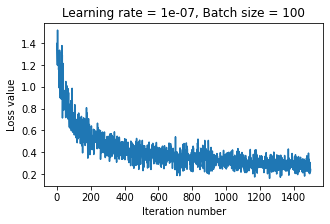

iteration 0 / 1500: loss 1.476420
iteration 100 / 1500: loss 0.572807
iteration 200 / 1500: loss 0.489823
iteration 300 / 1500: loss 0.416262
iteration 400 / 1500: loss 0.387247
iteration 500 / 1500: loss 0.407248
iteration 600 / 1500: loss 0.393511
iteration 700 / 1500: loss 0.383759
iteration 800 / 1500: loss 0.247297
iteration 900 / 1500: loss 0.213159
iteration 1000 / 1500: loss 0.259405
iteration 1100 / 1500: loss 0.208758
iteration 1200 / 1500: loss 0.252955
iteration 1300 / 1500: loss 0.168905
iteration 1400 / 1500: loss 0.200628


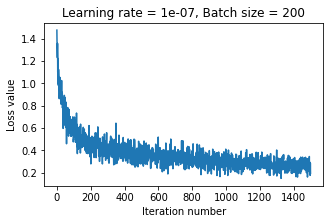

iteration 0 / 1500: loss 1.188909
iteration 100 / 1500: loss 0.770760
iteration 200 / 1500: loss 0.715108
iteration 300 / 1500: loss 0.591701
iteration 400 / 1500: loss 0.495692
iteration 500 / 1500: loss 0.459227
iteration 600 / 1500: loss 0.443941
iteration 700 / 1500: loss 0.363628
iteration 800 / 1500: loss 0.389668
iteration 900 / 1500: loss 0.379620
iteration 1000 / 1500: loss 0.361817
iteration 1100 / 1500: loss 0.315819
iteration 1200 / 1500: loss 0.253512
iteration 1300 / 1500: loss 0.325549
iteration 1400 / 1500: loss 0.263139


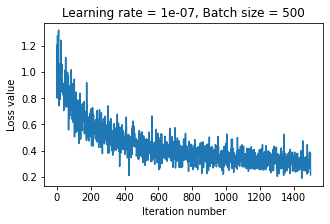

iteration 0 / 1500: loss 1.417010
iteration 100 / 1500: loss 0.402756
iteration 200 / 1500: loss 0.551046
iteration 300 / 1500: loss 0.730264
iteration 400 / 1500: loss 0.279782
iteration 500 / 1500: loss 0.503845
iteration 600 / 1500: loss 0.265286
iteration 700 / 1500: loss 0.458669
iteration 800 / 1500: loss 0.333265
iteration 900 / 1500: loss 0.190816
iteration 1000 / 1500: loss 0.212868
iteration 1100 / 1500: loss 0.169929
iteration 1200 / 1500: loss 1.367436
iteration 1300 / 1500: loss 0.124155
iteration 1400 / 1500: loss 0.686263


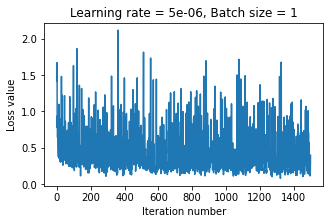

iteration 0 / 1500: loss 1.379941
iteration 100 / 1500: loss 0.687073
iteration 200 / 1500: loss 0.763274
iteration 300 / 1500: loss 0.473579
iteration 400 / 1500: loss 0.229417
iteration 500 / 1500: loss 0.440170
iteration 600 / 1500: loss 0.564635
iteration 700 / 1500: loss 0.448323
iteration 800 / 1500: loss 0.230115
iteration 900 / 1500: loss 0.559913
iteration 1000 / 1500: loss 0.366297
iteration 1100 / 1500: loss 0.294879
iteration 1200 / 1500: loss 0.466352
iteration 1300 / 1500: loss 0.147343
iteration 1400 / 1500: loss 0.279060


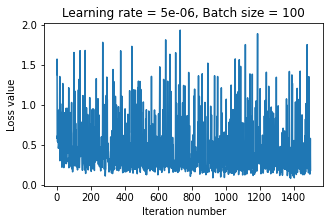

iteration 0 / 1500: loss 1.093733
iteration 100 / 1500: loss 0.306903
iteration 200 / 1500: loss 0.253237
iteration 300 / 1500: loss 0.277617
iteration 400 / 1500: loss 0.247368
iteration 500 / 1500: loss 0.133331
iteration 600 / 1500: loss 0.256526
iteration 700 / 1500: loss 0.153577
iteration 800 / 1500: loss 1.098330
iteration 900 / 1500: loss 0.088797
iteration 1000 / 1500: loss 0.257591
iteration 1100 / 1500: loss 0.910738
iteration 1200 / 1500: loss 0.159870
iteration 1300 / 1500: loss 0.630011
iteration 1400 / 1500: loss 0.429609


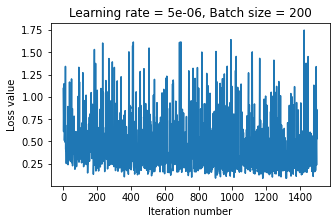

iteration 0 / 1500: loss 1.121611
iteration 100 / 1500: loss 0.549521
iteration 200 / 1500: loss 0.876082
iteration 300 / 1500: loss 0.153478
iteration 400 / 1500: loss 0.632140
iteration 500 / 1500: loss 0.375746
iteration 600 / 1500: loss 0.252242
iteration 700 / 1500: loss 0.173032
iteration 800 / 1500: loss 1.438350
iteration 900 / 1500: loss 0.283357
iteration 1000 / 1500: loss 0.721978
iteration 1100 / 1500: loss 0.386871
iteration 1200 / 1500: loss 0.245559
iteration 1300 / 1500: loss 1.244907
iteration 1400 / 1500: loss 0.129143


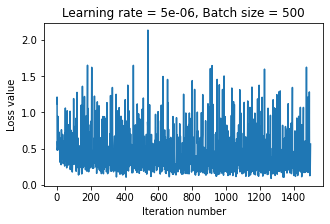

lr 1.000000e-07 batch_size 1.000000e+00 train accuracy: 0.737800 val accuracy: 0.738000
lr 1.000000e-07 batch_size 1.000000e+02 train accuracy: 0.736500 val accuracy: 0.745000
lr 1.000000e-07 batch_size 2.000000e+02 train accuracy: 0.737500 val accuracy: 0.744000
lr 1.000000e-07 batch_size 5.000000e+02 train accuracy: 0.722000 val accuracy: 0.737000
lr 5.000000e-06 batch_size 1.000000e+00 train accuracy: 0.734100 val accuracy: 0.751000
lr 5.000000e-06 batch_size 1.000000e+02 train accuracy: 0.813100 val accuracy: 0.799000
lr 5.000000e-06 batch_size 2.000000e+02 train accuracy: 0.753900 val accuracy: 0.764000
lr 5.000000e-06 batch_size 5.000000e+02 train accuracy: 0.743500 val accuracy: 0.748000
best validation accuracy achieved during cross-validation: 0.799000
linear perceptron on raw pixels final test set accuracy: 0.798000


In [21]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################

# perceptron = LinearPerceptron(X_train, y_train)
# loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7, 
#                                 num_iters=1500, verbose=True)



for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    model = LinearPerceptron(X_train, y_train)
    loss_history = model.train(X_train, y_train, learning_rate=lr, 
                                    num_iters=1500, verbose=True)
    train_accuracy = model.calc_accuracy(X_train, y_train)
    val_accuracy = model.calc_accuracy(X_val, y_val)
    results[(lr, batch_size)] = (train_accuracy, val_accuracy)
    # plot the loss history with title
    plt.plot(loss_history)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.title('Learning rate = {}, Batch size = {}'.format(lr, batch_size))
    plt.show()
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_perceptron = model



################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the perceptron loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Read the next code cell. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier. **(10 Points)**

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. 

In [22]:
def sigmoid(x):
    """
    Numerically stable Sigmoid function.

    Input: any unnormalized log probabilities vector
    Output: normalized probabilities
    """
    #############################################################################
    # Implement the function                                                    #
    #############################################################################

    sig = 1. / (1. + np.exp(-x))
    
    return sig
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [23]:
class LogisticRegression(LinearClassifier):
    # Classifer that uses sigmoid and binary cross entropy loss
    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        # Initiate the parameters of your model.                                  #
        ###########################################################################

        # initialize the weights from 0 and 1 with small numbers (multiply with 0.001 to scale the weights and prevent them from being too large)
        self.W = np.random.randn(X.shape[1], 1) * 0.001        
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # Implement this method.                                                  #
        ###########################################################################

        # calculate the scores
        z = np.dot(X, self.W)
        sig_z = sigmoid(z)
        
        # calculate the prediction
        y_pred = np.where(sig_z < 0.5, 0, 1)
        y_pred = np.squeeze(y_pred)
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        # will be implemented later
        return binary_cross_entropy(self.W, X_batch, y_batch)

In [24]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)


      car	      car	      car	      car


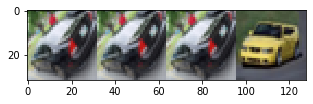

In [25]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [26]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane         plane           car           car


In [27]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  0.4974


## Binary cross-entropy

Your code for this section will written in the next cell. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W. (**20 points**)

In [28]:
def binary_cross_entropy(W, X, y):
    """
    Structured BCE loss function. Implement this function using vectorized code.
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with binary labels (0,1). 
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Implement the function and store result in loss and the gradint in dW     #
    # Note: in class you defined BCE that takes values from the range (-1,1).   #
    # and the sigmoid function generally outputs values in the range (0,1).     #
    # Make the proper adjustments for your code to work.                        #
    #############################################################################

    num_instances = X.shape[0]
    # calculate the scores
    z = np.dot(X, W)

    # change y from 0,1 to -1,1
    y_changed = (y * 2) - 1
    y_changed = np.reshape(y_changed, (y_changed.shape[0], 1))

    # calculate -tz
    minus_tz = -z * y_changed

    # calculate the sigmoid
    sigmoid_minus_tz = sigmoid(minus_tz) * (-1)

    # calculate tx
    tx = y_changed * X

    # calculate gradient
    gradient = np.dot(tx.T, sigmoid_minus_tz)
    
    # calculate the loss
    loss = np.log(1 + np.exp(minus_tz)) - np.log(1)
    loss = np.sum(loss)

    # average the loss and gradient over the number of samples
    loss /= num_instances
    dW = gradient / num_instances


    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [29]:
W = np.random.randn(3073, 1) * 0.0001

In [30]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.681560
CPU times: total: 0 ns
Wall time: 15.9 ms


You are provided with a gradient test in the next cells:

In [31]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [32]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 6.732395 analytic: 6.732395, relative error: 3.204900e-09
numerical: 4.210061 analytic: 4.210060, relative error: 7.507455e-09
numerical: 3.917940 analytic: 3.917940, relative error: 1.438472e-11
numerical: 3.560068 analytic: 3.560068, relative error: 1.108819e-08
numerical: 12.053900 analytic: 12.053900, relative error: 2.483536e-10
numerical: 4.277155 analytic: 4.277155, relative error: 3.770029e-09
numerical: 3.314666 analytic: 3.314666, relative error: 1.762931e-08


numerical: 13.050270 analytic: 13.050270, relative error: 1.645611e-09
numerical: 10.843712 analytic: 10.843712, relative error: 2.063474e-09
numerical: -3.868551 analytic: -3.868551, relative error: 7.781473e-09


If implemented correctly, the training procedure you already implemented should work.

In [33]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 1.688783
iteration 100 / 1500: loss 1.039319
iteration 200 / 1500: loss 0.772160
iteration 300 / 1500: loss 0.623611
iteration 400 / 1500: loss 0.600997
iteration 500 / 1500: loss 0.580809
iteration 600 / 1500: loss 0.568007
iteration 700 / 1500: loss 0.555312
iteration 800 / 1500: loss 0.533064
iteration 900 / 1500: loss 0.509809
iteration 1000 / 1500: loss 0.559864
iteration 1100 / 1500: loss 0.465087
iteration 1200 / 1500: loss 0.635681
iteration 1300 / 1500: loss 0.530077
iteration 1400 / 1500: loss 0.486951
CPU times: total: 3.23 s
Wall time: 9.15 s


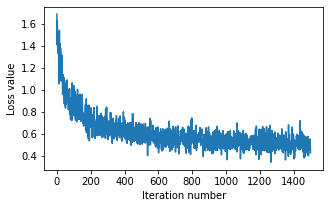

In [34]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [35]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  0.7729
Testing accuracy:  0.777


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. **(5 points)**

iteration 0 / 1500: loss 1.636372
iteration 100 / 1500: loss 1.148628
iteration 200 / 1500: loss 0.824493
iteration 300 / 1500: loss 0.760175
iteration 400 / 1500: loss 0.603741
iteration 500 / 1500: loss 0.659002
iteration 600 / 1500: loss 0.733336
iteration 700 / 1500: loss 0.639335
iteration 800 / 1500: loss 0.731362
iteration 900 / 1500: loss 0.577253
iteration 1000 / 1500: loss 0.749085
iteration 1100 / 1500: loss 0.614525
iteration 1200 / 1500: loss 0.579499
iteration 1300 / 1500: loss 0.470620
iteration 1400 / 1500: loss 0.522355


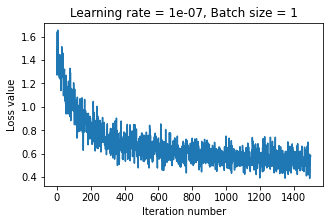

iteration 0 / 1500: loss 2.346345
iteration 100 / 1500: loss 0.783980
iteration 200 / 1500: loss 0.740306
iteration 300 / 1500: loss 0.722648
iteration 400 / 1500: loss 0.574677
iteration 500 / 1500: loss 0.563178
iteration 600 / 1500: loss 0.579692
iteration 700 / 1500: loss 0.536633
iteration 800 / 1500: loss 0.631531
iteration 900 / 1500: loss 0.507324
iteration 1000 / 1500: loss 0.424121
iteration 1100 / 1500: loss 0.536599
iteration 1200 / 1500: loss 0.574626
iteration 1300 / 1500: loss 0.620207
iteration 1400 / 1500: loss 0.507042


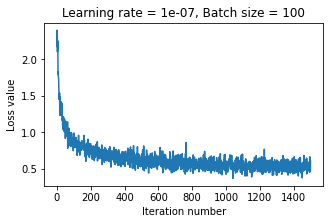

iteration 0 / 1500: loss 1.908881
iteration 100 / 1500: loss 0.963860
iteration 200 / 1500: loss 0.658471
iteration 300 / 1500: loss 0.766552
iteration 400 / 1500: loss 0.600575
iteration 500 / 1500: loss 0.625088
iteration 600 / 1500: loss 0.671530
iteration 700 / 1500: loss 0.661009
iteration 800 / 1500: loss 0.620093
iteration 900 / 1500: loss 0.730640
iteration 1000 / 1500: loss 0.584287
iteration 1100 / 1500: loss 0.648839
iteration 1200 / 1500: loss 0.558207
iteration 1300 / 1500: loss 0.468446
iteration 1400 / 1500: loss 0.576117


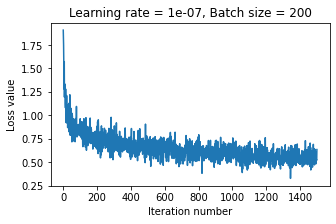

iteration 0 / 1500: loss 1.940992
iteration 100 / 1500: loss 0.874202
iteration 200 / 1500: loss 0.918284
iteration 300 / 1500: loss 0.623040
iteration 400 / 1500: loss 0.630501
iteration 500 / 1500: loss 0.626063
iteration 600 / 1500: loss 0.528507
iteration 700 / 1500: loss 0.572592
iteration 800 / 1500: loss 0.446190
iteration 900 / 1500: loss 0.526659
iteration 1000 / 1500: loss 0.532106
iteration 1100 / 1500: loss 0.429194
iteration 1200 / 1500: loss 0.581363
iteration 1300 / 1500: loss 0.481138
iteration 1400 / 1500: loss 0.542378


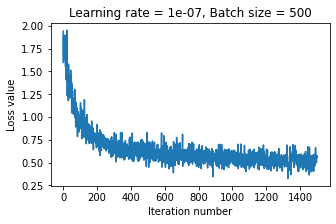

iteration 0 / 1500: loss 2.538871
iteration 100 / 1500: loss 0.593672
iteration 200 / 1500: loss 0.405513
iteration 300 / 1500: loss 0.721915
iteration 400 / 1500: loss 0.426553
iteration 500 / 1500: loss 0.376714
iteration 600 / 1500: loss 0.388056
iteration 700 / 1500: loss 0.404149
iteration 800 / 1500: loss 0.362611
iteration 900 / 1500: loss 0.373658
iteration 1000 / 1500: loss 0.458258
iteration 1100 / 1500: loss 0.499494
iteration 1200 / 1500: loss 0.665085
iteration 1300 / 1500: loss 0.355228
iteration 1400 / 1500: loss 0.335075


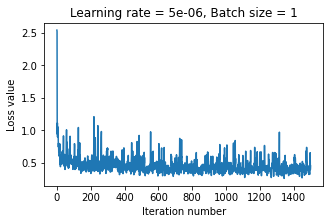

iteration 0 / 1500: loss 1.302419
iteration 100 / 1500: loss 0.441080
iteration 200 / 1500: loss 0.464265
iteration 300 / 1500: loss 0.477224
iteration 400 / 1500: loss 0.496488
iteration 500 / 1500: loss 0.393881
iteration 600 / 1500: loss 0.324938
iteration 700 / 1500: loss 0.420182
iteration 800 / 1500: loss 0.479953
iteration 900 / 1500: loss 0.409757
iteration 1000 / 1500: loss 0.466719
iteration 1100 / 1500: loss 0.380521
iteration 1200 / 1500: loss 0.332330
iteration 1300 / 1500: loss 0.576628
iteration 1400 / 1500: loss 0.332663


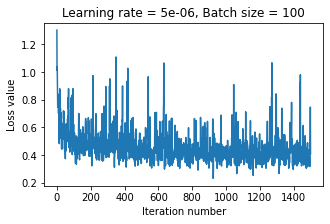

iteration 0 / 1500: loss 1.823161
iteration 100 / 1500: loss 0.523815
iteration 200 / 1500: loss 0.438764
iteration 300 / 1500: loss 1.272794
iteration 400 / 1500: loss 0.627471
iteration 500 / 1500: loss 0.408040
iteration 600 / 1500: loss 0.435740
iteration 700 / 1500: loss 0.328473
iteration 800 / 1500: loss 0.424885
iteration 900 / 1500: loss 0.352532
iteration 1000 / 1500: loss 0.429100
iteration 1100 / 1500: loss 0.448740
iteration 1200 / 1500: loss 0.333842
iteration 1300 / 1500: loss 0.627302
iteration 1400 / 1500: loss 0.466372


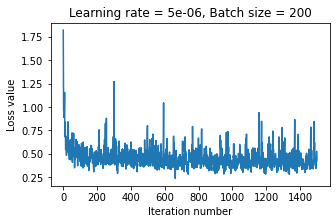

iteration 0 / 1500: loss 3.274839
iteration 100 / 1500: loss 0.566264
iteration 200 / 1500: loss 0.463071
iteration 300 / 1500: loss 0.558136
iteration 400 / 1500: loss 0.544484
iteration 500 / 1500: loss 0.424234
iteration 600 / 1500: loss 0.355381
iteration 700 / 1500: loss 0.347110
iteration 800 / 1500: loss 0.473669
iteration 900 / 1500: loss 0.344526
iteration 1000 / 1500: loss 0.395228
iteration 1100 / 1500: loss 0.328318
iteration 1200 / 1500: loss 0.476648
iteration 1300 / 1500: loss 0.374044
iteration 1400 / 1500: loss 0.589936


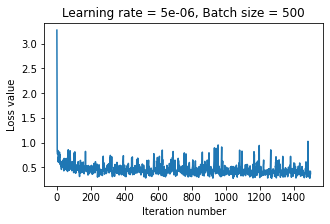

lr 1.000000e-07 batch_size 1.000000e+00 train accuracy: 0.767200 val accuracy: 0.759000
lr 1.000000e-07 batch_size 1.000000e+02 train accuracy: 0.768700 val accuracy: 0.797000
lr 1.000000e-07 batch_size 2.000000e+02 train accuracy: 0.758400 val accuracy: 0.774000
lr 1.000000e-07 batch_size 5.000000e+02 train accuracy: 0.770400 val accuracy: 0.786000
lr 5.000000e-06 batch_size 1.000000e+00 train accuracy: 0.805000 val accuracy: 0.797000
lr 5.000000e-06 batch_size 1.000000e+02 train accuracy: 0.834600 val accuracy: 0.819000
lr 5.000000e-06 batch_size 2.000000e+02 train accuracy: 0.832500 val accuracy: 0.828000
lr 5.000000e-06 batch_size 5.000000e+02 train accuracy: 0.842100 val accuracy: 0.841000
best validation accuracy achieved during cross-validation: 0.841000
Binary logistic regression on raw pixels final test set accuracy: 0.803000


In [36]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################

for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    model = LogisticRegression(X_train, y_train)
    loss_history = model.train(X_train, y_train, learning_rate=lr, 
                                    num_iters=1500, verbose=True)
    train_accuracy = model.calc_accuracy(X_train, y_train)
    val_accuracy = model.calc_accuracy(X_val, y_val)
    results[(lr, batch_size)] = (train_accuracy, val_accuracy)
    # plot the loss history with title
    plt.plot(loss_history)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.title('Learning rate = {}, Batch size = {}'.format(lr, batch_size))
    plt.show()
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_logistic = model


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

# The End!